In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [3]:
X = np.load('/content/drive/My Drive/DATASET/BREASTHISTOLOGYIDC/X.npy') # images
Y = np.load('/content/drive/My Drive/DATASET/BREASTHISTOLOGYIDC/Y.npy') # labels associated to images (0 = no cancer, 1 = cancer)

In [4]:
print('Total number of images : {}'.format(len(X)))
print('Number of images without cancer : {}'.format(np.sum(Y==0)))
print('Number of images with cancer : {}'.format(np.sum(Y==1)))
print('Percentage of positive images : {:.2f}%'.format(100*np.mean(Y)))

print('Image shape (number of rows, number of columns, channels RGB): {}'.format(X[0].shape))

Total number of images : 5547
Number of images without cancer : 2759
Number of images with cancer : 2788
Percentage of positive images : 50.26%
Image shape (number of rows, number of columns, channels RGB): (50, 50, 3)


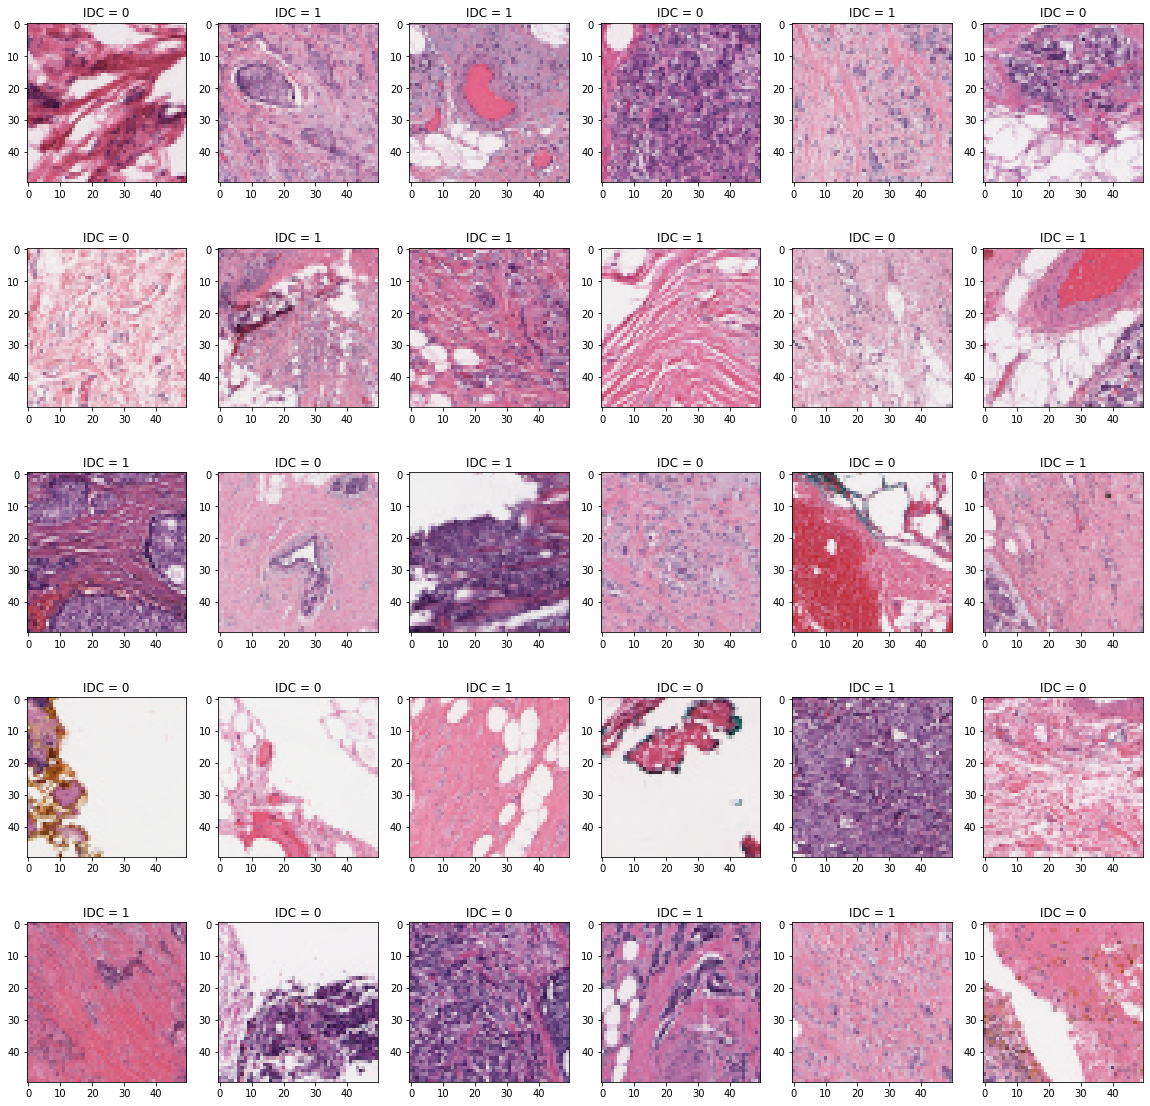

In [5]:
# Shuffling Data
perm_array = np.arange(len(X))
np.random.shuffle(perm_array)
X = X[perm_array]
Y = Y[perm_array]

# Plotting Some Images
imgs_0 = X[Y == 0] # 0 = Non IDC
imgs_1 = X[Y == 1] # 1 = IDC

plt.figure(figsize=(20,20))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.title('IDC = %d'%Y[i])
    plt.imshow(X[i])

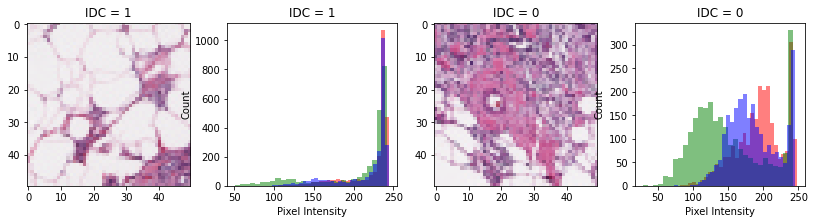

In [6]:
# Plotting Histogram of Red, Green & Blue Pixel Intensities

plt.figure(figsize=(14,3))

for i in range(2):
    n_img = np.random.randint(len(X))
    plt.subplot(1,4,1+2*i)
    plt.title('IDC = %d'%Y[n_img])
    plt.imshow(X[n_img])
    plt.subplot(1,4,2+2*i)
    plt.title('IDC = %d'%Y[n_img])
    plt.ylabel('Count')
    plt.xlabel('Pixel Intensity')
    plt.hist(X[n_img,:,:,0].flatten(), bins=30, lw = 0,color='r', alpha=0.5);
    plt.hist(X[n_img,:,:,1].flatten(), bins=30, lw = 0, color='g', alpha=0.5);
    plt.hist(X[n_img,:,:,2].flatten(), bins=30, lw = 0, color='b', alpha=0.5);

In [7]:
from sklearn.model_selection import train_test_split
Y = Y.reshape(Y.shape[0],1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# Normalizing the data
xtrain = X_train/225
xtest = X_test/225

print("Shape of Training Data:", xtrain.shape, xtrain.shape)
print("Shape of Validation Data:", xtest.shape, xtest.shape)

Shape of Training Data: (4437, 50, 50, 3) (4437, 50, 50, 3)
Shape of Validation Data: (1110, 50, 50, 3) (1110, 50, 50, 3)


In [8]:
import keras
from keras.models import Sequential
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.models import model_from_json
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras import layers
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping

In [9]:
from keras.utils import np_utils
ytrain = np_utils.to_categorical(y_train, num_classes = 2)
ytest = np_utils.to_categorical(y_test, num_classes = 2)

In [10]:
xtrain.shape

(4437, 50, 50, 3)

In [11]:
from keras.layers import Input, Lambda, Dense, Flatten, MaxPooling2D
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
from keras import optimizers

In [12]:
# Membuat Model CNN 
IMG_SIZE = 50
NUM_CLASSES = 2

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=[IMG_SIZE,IMG_SIZE] + [3], strides=1))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 33856)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4333696   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [13]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

train_datagen = ImageDataGenerator(featurewise_center=False,  # set input mean to 0 over the dataset
                                    samplewise_center=False,  # set each sample mean to 0
                                    featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                    samplewise_std_normalization=False,  # divide each input by its std
                                    zca_whitening=False,  # apply ZCA whitening
                                    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
                                    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
                                    height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
                                    horizontal_flip=True,  # randomly flip images
                                    vertical_flip=True)  # randomly flip images                         
                             
train_generator = train_datagen.flow(xtrain, ytrain, batch_size = 32, shuffle = False)

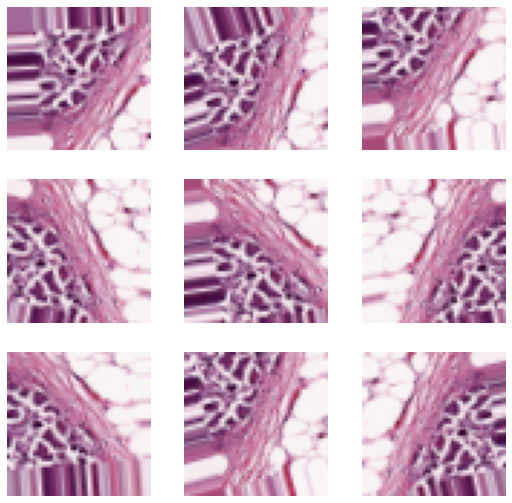

In [14]:
x = img_to_array(keras.preprocessing.image.array_to_img(xtrain[3]))
x2 = x.reshape((1,) + x.shape)
i = 0
fig = plt.figure(figsize = (9,9))
plt.title('Pre-processed')
for batch in train_datagen.flow(x2, batch_size = 1):
    i += 1
    if i > 9:
        break
    temp = batch.reshape(x.shape)
    plt.subplot(3, 3, i)
    plt.imshow(temp.astype('uint8'))
    plt.axis('off')
plt.show()

In [15]:
#Membuat EarlyStopping
es = EarlyStopping(
                    monitor='val_accuracy', 
                    mode='max',
                    patience=10
                  )

In [16]:
#fit the model 
history = model.fit(train_generator,
                    validation_data=(xtest,ytest), 
                    epochs=30,
                    callbacks=[es]
                    )    

Epoch 1/30
139/139 [==============================] - 37s 269ms/step - loss: 0.6528 - accuracy: 0.6196 - val_loss: 0.7726 - val_accuracy: 0.5306
Epoch 2/30
139/139 [==============================] - 37s 266ms/step - loss: 0.5903 - accuracy: 0.6980 - val_loss: 0.5500 - val_accuracy: 0.7568
Epoch 3/30
139/139 [==============================] - 37s 263ms/step - loss: 0.5807 - accuracy: 0.7147 - val_loss: 0.5544 - val_accuracy: 0.7541
Epoch 4/30
139/139 [==============================] - 36s 262ms/step - loss: 0.5692 - accuracy: 0.7235 - val_loss: 0.5368 - val_accuracy: 0.7604
Epoch 5/30
139/139 [==============================] - 37s 266ms/step - loss: 0.5599 - accuracy: 0.7268 - val_loss: 0.5719 - val_accuracy: 0.7171
Epoch 6/30
139/139 [==============================] - 37s 265ms/step - loss: 0.5561 - accuracy: 0.7302 - val_loss: 0.5604 - val_accuracy: 0.7126
Epoch 7/30
139/139 [==============================] - 37s 263ms/step - loss: 0.5620 - accuracy: 0.7309 - val_loss: 0.5136 - val_ac

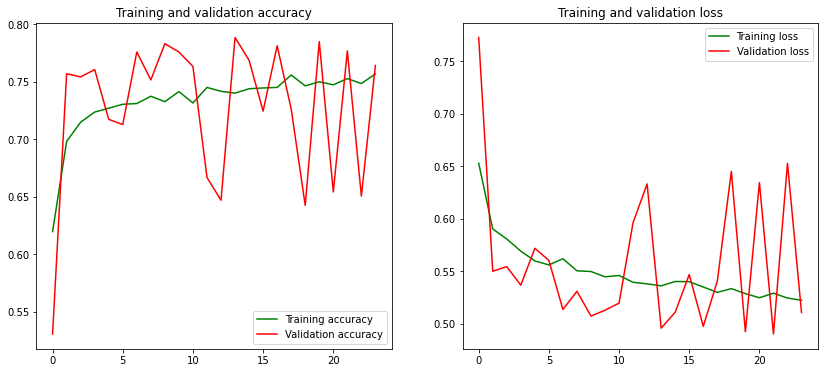

In [17]:
def plot_accuracy_and_loss(history):
    hist = history.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(history)

In [18]:
train_loss, train_acc = model.evaluate(xtrain,  ytrain, verbose=2)
test_loss, test_acc = model.evaluate(xtest,  ytest, verbose=2)
print("Training accuracy= ", train_acc)
print("Validation accuracy= ", test_acc)

139/139 - 9s - loss: 0.5224 - accuracy: 0.7440
35/35 - 2s - loss: 0.5108 - accuracy: 0.7640
Training accuracy=  0.7439711689949036
Validation accuracy=  0.7639639377593994


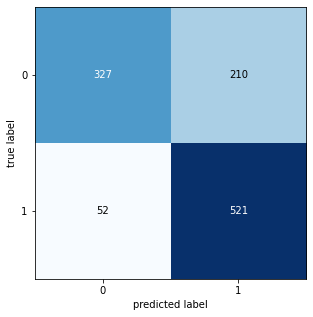

In [19]:
from sklearn.metrics import confusion_matrix
pred = model.predict(xtest)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(ytest,axis = 1)

CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [20]:
from sklearn import metrics
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, pred, digits=2,  target_names = ["Benign","Malignant"]))

              precision    recall  f1-score   support

      Benign       0.86      0.61      0.71       537
   Malignant       0.71      0.91      0.80       573

    accuracy                           0.76      1110
   macro avg       0.79      0.76      0.76      1110
weighted avg       0.79      0.76      0.76      1110



# XGBoost Implementation

In [22]:
#Mengambil layer terakhir dari model
model_feat = Model(inputs=model.input,outputs=model.get_layer

('dense_1').output)

feat_train = model_feat.predict(xtrain)
print(feat_train.shape)


feat_test = model_feat.predict(xtest)
print(feat_test.shape)

(4437, 2)
(1110, 2)


In [23]:
import xgboost as xgb
from xgboost import XGBClassifier

xgbc = xgb.XGBClassifier()

xgbc.fit(feat_train,np.argmax(ytrain,axis=1))

print('fitting done !!!')

fitting done !!!


Training Score

In [37]:
print ('Training accuracy after XGB =', xgbc.score(feat_train,np.argmax(ytrain,axis=1)))

Training accuracy after XGB = 0.7734956051386072


Validation Score

In [35]:
print ('Validation accuracy after XGB =', xgbc.score(feat_test,np.argmax(ytest,axis=1)))

Validation accuracy after XGB = 0.7774774774774775


In [26]:
Predxgb = xgbc.predict(feat_test)

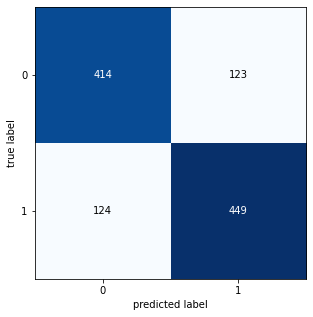

In [27]:
CM = confusion_matrix(y_true, Predxgb)
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [28]:
from sklearn import metrics
# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, Predxgb, digits=2,  target_names = ["Benign","Malignant"]))

              precision    recall  f1-score   support

      Benign       0.77      0.77      0.77       537
   Malignant       0.78      0.78      0.78       573

    accuracy                           0.78      1110
   macro avg       0.78      0.78      0.78      1110
weighted avg       0.78      0.78      0.78      1110



In [29]:
# save model and architecture to single file
model.save("breastcancer.h5")
print("Saved model to disk")

Saved model to disk
